## Step 1: Data acquisition

- In order to measure Wikipedia traffic from 2008-2019, we will need to collect data from two different API endpoints, the Legacy Pagecounts API (December 2007 through July 2016) and the Pageviews API(July 2015 through September 2019).

- For each API, we will need to collect data for all months where data is available and then save the raw results into 5 separate JSON source data files (one file per API query type).

- The Pageview API (but not the Pagecount API) allows us to filter by agent=user to filter our web crawlers.


In [26]:
# Importing Libraries
import json
import requests
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# APIs

# pagecount
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
# pageview
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [3]:
"""
    Pagecount API
    parameters for getting aggregated legacy view data
    see: https://wikimedia.org/api/rest_v1/#/ for details 
"""

#all-sites
example_params_legacy1 = {"project" : "en.wikipedia.org",
                 "access-site" : "all-sites",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                # for end use 1st day of month following final month of data
                 "end" : "2016070100"
                    }
#mobile-site
example_params_legacy2 = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                # for end use 1st day of month following final month of data
                 "end" : "2016070100"
                    }

#desktop-site
example_params_legacy3 = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                # for end use 1st day of month following final month of data
                 "end" : "2016070100"
                    }

"""
  Pageview API
  see: https://wikimedia.org/api/rest_v1/#/ for details
"""
#mobile-app
example_params_pageviews4 = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2019091000'
                        }

#mobile-web
example_params_pageviews5 = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    # for end use 1st day of month following final month of data
                    "end" : '2019091000'
                        }

# Customized headers with my information
headers = {
    'User-Agent': 'https://github.com/ishna',
    'From': 'ishnak@uw.edu'
}

In [4]:
# Function to make the API call
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    # loads the json file
    return response

#### Making the 5 json file calls and storing them in given format

In [5]:
# All monthly pagecount data
all_monthly_legacy = api_call(endpoint_legacy, example_params_legacy1)
with open("pagecounts_all-sites_200712-201607.json", "w") as f:
    #Write it to file
    json.dump(all_monthly_legacy, f)

In [6]:
# Monthly mobile pagecount data
mobile_monthly_legacy = api_call(endpoint_legacy, example_params_legacy2)
with open("pagecounts_mobile-site_200712-201607.json", "w") as f:
    #Write it to file
    json.dump(mobile_monthly_legacy, f)

In [7]:
# Monthly desktop pagecount data
desktop_monthly_legacy = api_call(endpoint_legacy, example_params_legacy3)
with open("pagecounts_desktop-site_200712-201607.json", "w") as f:
    #Write it to file
    json.dump(desktop_monthly_legacy, f)

In [8]:
# Monthly mobile pageview data
mobileapp_monthly_pageview = api_call(endpoint_pageviews, example_params_pageviews4)
with open("pageview_mobile-app_201507-201909.json", "w") as f:
    #Write it to file
    json.dump(mobileapp_monthly_pageview, f)

In [9]:
# Monthly desktop mobile pageview data
mobileweb_monthly_pageview = api_call(endpoint_pageviews, example_params_pageviews5)
with open("pageview_mobile-web_201507-201909.json", "w") as f:
    #Write it to file
    json.dump(mobileweb_monthly_pageview, f)

## Step 2: Data processing

We will need to perform a series of processing steps on these data files in order to prepare them for analysis. 

- For data collected from the Pageviews API, we combine the monthly values for mobile-app and mobile-web to create a total mobile traffic count for each month.
- For all data, separate the value of timestamp into four-digit year (YYYY) and two-digit month (MM) and discard values for day and hour (DDHH).
- For all months with 0 pageviews for a given access method (e.g. desktop-site, mobile-app), that value for that (column, month) should be listed as 0
- Combine all data into a single CSV file 

#### Converting the json to pandas dataframe

In [10]:
def convert_to_pd(json_file):
    items = json_file['items']
    testdf = pd.DataFrame(items)
    # Seperating month and year 
    testdf["month"] = testdf['timestamp'].astype(str).str[4:6]
    testdf["year"] = testdf['timestamp'].astype(str).str[0:4]
    return testdf

In [11]:
# All legacy monthly data
all_monthly_legacy_pd = convert_to_pd(all_monthly_legacy)
all_monthly_legacy_pd = all_monthly_legacy_pd.rename(columns={'count': 'pagecount_all_views'})
all_monthly_legacy_pd = all_monthly_legacy_pd.drop(['access-site', 'granularity', "project", "timestamp"], axis=1)


In [12]:
# All desktop monthly data
desktop_monthly_legacy_pd = convert_to_pd(desktop_monthly_legacy)
desktop_monthly_legacy_pd = desktop_monthly_legacy_pd.rename(columns={'count': 'pagecount_desktop_views'})
desktop_monthly_legacy_pd = desktop_monthly_legacy_pd.drop(['access-site', 'granularity', "project", "timestamp"], axis=1)


In [13]:
# All mobile monthly data
mobile_monthly_legacy_pd = convert_to_pd(mobile_monthly_legacy)
mobile_monthly_legacy_pd = mobile_monthly_legacy_pd.rename(columns={'count': 'pagecount_mobile_views'})
mobile_monthly_legacy_pd = mobile_monthly_legacy_pd.drop(['access-site', 'granularity', "project", "timestamp"], axis=1)


#### Merging data from legacy counts

In [14]:

legacy_count1 = pd.merge(all_monthly_legacy_pd , desktop_monthly_legacy_pd, how='left', on=['year', 'month'])
legacy_count = pd.merge(legacy_count1 , mobile_monthly_legacy_pd, how='left', on=['year', 'month'])

In [15]:
# All page count data
legacy_count

,pagecount_all_views,month,year,pagecount_desktop_views,pagecount_mobile_views
0,2998331524,12,2007,2998331524,NaN
1,4930902570,01,2008,4930902570,NaN
2,4818393763,02,2008,4818393763,NaN
3,4955405809,03,2008,4955405809,NaN
4,5159162183,04,2008,5159162183,NaN
5,5584691092,05,2008,5584691092,NaN
6,5712104279,06,2008,5712104279,NaN
7,5306302874,07,2008,5306302874,NaN
8,5140155519,08,2008,5140155519,NaN
9,5479533823,09,2008,5479533823,NaN


#### Merging data from pageviews API

In [16]:
# Mobile-app monthly data
mobileapp_monthly_pageview_pd = convert_to_pd(mobileapp_monthly_pageview)
mobileapp_monthly_pageview_pd = mobileapp_monthly_pageview_pd.rename(columns={'views': 'pageview_mobile_views'})
mobileapp_monthly_pageview_pd = mobileapp_monthly_pageview_pd.drop(['agent', 'access', 'granularity', "project", "timestamp"], axis=1)


In [17]:
# Mobile-web monthly data
mobileweb_monthly_pageview_pd = convert_to_pd(mobileweb_monthly_pageview)
mobileweb_monthly_pageview_pd = mobileweb_monthly_pageview_pd.rename(columns={'views': 'pageview_desktop_views'})
mobileweb_monthly_pageview_pd = mobileweb_monthly_pageview_pd.drop(['agent','access', 'granularity', "project", "timestamp"], axis=1)


#### Merging data from pageview API

In [18]:
page_view = pd.merge(mobileapp_monthly_pageview_pd , mobileweb_monthly_pageview_pd, how='left', on=['year', 'month'])
# Total views = sum of mobile + site
page_view['pageview_all_views'] = page_view['pageview_mobile_views'] + page_view['pageview_desktop_views']


In [19]:
# All pageview data
page_view

,pageview_mobile_views,month,year,pageview_desktop_views,pageview_all_views
0,109624146,07,2015,3179131148,3288755294
1,109669149,08,2015,3192663889,3302333038
2,96221684,09,2015,3073981649,3170203333
3,94523777,10,2015,3173975355,3268499132
4,94353925,11,2015,3142247145,3236601070
5,99438956,12,2015,3276836351,3376275307
6,106432767,01,2016,3611404079,3717836846
7,92414130,02,2016,3242448142,3334862272
8,97899074,03,2016,3288785117,3386684191
9,81719003,04,2016,3177044999,3258764002


#### Combining all data

In [30]:
# Outerjoin on combined tables
overall = pd.merge(legacy_count , page_view, how='outer', on=['year', 'month'])
overall = overall.fillna(0)
overall

,pagecount_all_views,month,year,pagecount_desktop_views,pagecount_mobile_views,pageview_mobile_views,pageview_desktop_views,pageview_all_views
0,2.998332e+09,12,2007,2.998332e+09,0.0,0.0,0.000000e+00,0.000000e+00
1,4.930903e+09,01,2008,4.930903e+09,0.0,0.0,0.000000e+00,0.000000e+00
2,4.818394e+09,02,2008,4.818394e+09,0.0,0.0,0.000000e+00,0.000000e+00
3,4.955406e+09,03,2008,4.955406e+09,0.0,0.0,0.000000e+00,0.000000e+00
4,5.159162e+09,04,2008,5.159162e+09,0.0,0.0,0.000000e+00,0.000000e+00
5,5.584691e+09,05,2008,5.584691e+09,0.0,0.0,0.000000e+00,0.000000e+00
6,5.712104e+09,06,2008,5.712104e+09,0.0,0.0,0.000000e+00,0.000000e+00
7,5.306303e+09,07,2008,5.306303e+09,0.0,0.0,0.000000e+00,0.000000e+00
8,5.140156e+09,08,2008,5.140156e+09,0.0,0.0,0.000000e+00,0.000000e+00
9,5.479534e+09,09,2008,5.479534e+09,0.0,0.0,0.000000e+00,0.000000e+00


#### Pushing this to csv file:

In [31]:
overall.to_csv('en-wikipedia_traffic_200712-201809.csv')

## Step 3: Analysis

Visualize the dataset you have created as a time series graph.

Our visualization will track three traffic metrics: mobile traffic, desktop traffic, and all traffic (mobile + desktop).

In [50]:
# Adding columns for total, mobile and desktop views
overall["mobile"] = overall["pagecount_mobile_views"] + overall ["pageview_mobile_views"]
overall ["desktop"] = overall["pagecount_desktop_views"] + overall ["pageview_desktop_views"]
overall ["total"] = overall["mobile"] + overall ["desktop"]

In [51]:
overall

,pagecount_all_views,month,year,pagecount_desktop_views,pagecount_mobile_views,pageview_mobile_views,pageview_desktop_views,pageview_all_views,mobile,desktop,total
0,2.998332e+09,12,2007,2.998332e+09,0.0,0.0,0.000000e+00,0.000000e+00,0.0,2.998332e+09,2.998332e+09
1,4.930903e+09,01,2008,4.930903e+09,0.0,0.0,0.000000e+00,0.000000e+00,0.0,4.930903e+09,4.930903e+09
2,4.818394e+09,02,2008,4.818394e+09,0.0,0.0,0.000000e+00,0.000000e+00,0.0,4.818394e+09,4.818394e+09
3,4.955406e+09,03,2008,4.955406e+09,0.0,0.0,0.000000e+00,0.000000e+00,0.0,4.955406e+09,4.955406e+09
4,5.159162e+09,04,2008,5.159162e+09,0.0,0.0,0.000000e+00,0.000000e+00,0.0,5.159162e+09,5.159162e+09
5,5.584691e+09,05,2008,5.584691e+09,0.0,0.0,0.000000e+00,0.000000e+00,0.0,5.584691e+09,5.584691e+09
6,5.712104e+09,06,2008,5.712104e+09,0.0,0.0,0.000000e+00,0.000000e+00,0.0,5.712104e+09,5.712104e+09
7,5.306303e+09,07,2008,5.306303e+09,0.0,0.0,0.000000e+00,0.000000e+00,0.0,5.306303e+09,5.306303e+09
8,5.140156e+09,08,2008,5.140156e+09,0.0,0.0,0.000000e+00,0.000000e+00,0.0,5.140156e+09,5.140156e+09
9,5.479534e+09,09,2008,5.479534e+09,0.0,0.0,0.000000e+00,0.000000e+00,0.0,5.479534e+09,5.479534e+09


#### Plotting the graphs and saving the visualization

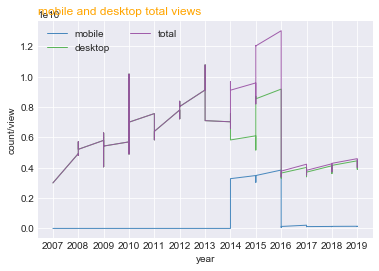

In [53]:
# Make a data frame
df=pd.DataFrame({'x': range(1,11), 'y1': np.random.randn(10), 'y2': np.random.randn(10)+range(1,11), 'y3': np.random.randn(10)+range(11,21), 'y4': np.random.randn(10)+range(6,16), 'y5': np.random.randn(10)+range(4,14)+(0,0,0,0,0,0,0,-3,-8,-6), 'y6': np.random.randn(10)+range(2,12), 'y7': np.random.randn(10)+range(5,15), 'y8': np.random.randn(10)+range(4,14), 'y9': np.random.randn(10)+range(4,14), 'y10': np.random.randn(10)+range(2,12) })
 
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
df = overall[overall.columns[-3:]]

# multiple line plot
num=0
for column in df:
    num+=1
    plt.plot(overall['year'], df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)
    # Add legend
    plt.legend(loc=2, ncol=2)
 
    # Add titles
    plt.title("mobile and desktop total views", loc='left', fontsize=12, fontweight=0, color='orange')
    plt.xlabel("year")
    plt.ylabel("count/view")
    plt.savefig('testplot.png')
